# Rule: **add_electricity**

**Summary**

Adds electrical generators and existing hydro storage units to a base network.

**Outputs:**

- resources/networks/`elec.nc`


**Description:**

This rule ties all the different data inputs from the preceding rules together into a detailed PyPSA network. It includes:

- today's transmission topology and transfer capacities (optionally including lines which are under construction according to the config settings ``lines: under_construction`` and ``links: under_construction``),
- today's thermal and hydro power generation capacities (for the technologies listed in the config setting ``electricity: conventional_carriers``), and
- today's load time-series (upsampled in a top-down approach according to population and gross domestic product)

It further adds extendable ``generators`` with **zero** capacity for

- photovoltaic, onshore and AC- as well as DC-connected offshore wind installations with today's locational, hourly wind and solar capacity factors (but **no** current capacities),
- additional open- and combined-cycle gas turbines (if ``OCGT`` and/or ``CCGT`` is listed in the config setting ``electricity: extendable_carriers``)


**Comments:**

- Two generators of the same carrier (e.g. CCGT) may coexist at the same bus, one with imported capacity, and other with zero capacity due to "everywhere".

- Capital costs for offwind-ac, offwind-dc and offwind-floating generators are different at each node according to grid connection costs (different distance).

- Note that capital costs assigned to generators are annualised [EUR/MW·year], while the capital costs in *costs.csv* are for the whole lifetime [EUR/kW].

- However, note that cost data are overwritten later at `prepare_sector_network` (TO CHECK)

In [1]:
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import yaml
import os 
import sys


##### Local funs
funs_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'local_funs'))
sys.path.append(funs_path)

from fun_map_add_features import fun_map_add_features
from fun_map_network_shapes import fun_map_network_shapes
from fun_map_capacity_Voronoi import fun_map_capacity_Voronoi
from fun_map_capacity_NUTS import fun_map_capacity_NUTS


##### Warnings setup
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



In [2]:
######################################## Parameters

with open('../config.yaml', 'r') as configfile:
    config = yaml.safe_load(configfile)

rootpath = config['notebook']['rootpath']
prefix = config['notebook']['prefix']
name = config['notebook']['name']

boundaries_onshore = config['map']['boundaries_onshore']
boundaries_offshore = config['map']['boundaries_offshore']

## `elec.nc`

In [3]:
file = f'elec.nc'
path = f'{rootpath}/resources/{prefix}/{name}/networks/'

n = pypsa.Network(path+file)

n

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units, transformers


PyPSA Network 'PyPSA-Spain'
Components:
 - Bus: 1109
 - Carrier: 12
 - Generator: 3331
 - Line: 1474
 - Link: 1
 - Load: 522
 - Shape: 1100
 - StorageUnit: 109
 - Transformer: 84
Snapshots: 8760

Text(0.5, 1.0, 'elec.nc')

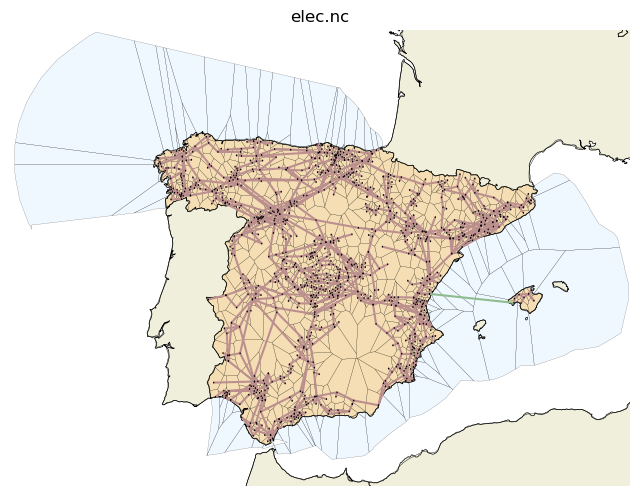

In [4]:
########## Plot the network

bus_sizes = 0.0005
bus_colors = 'black'


fig_size = [8,12]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network
n.plot(ax=ax, bus_sizes=bus_sizes, bus_colors=bus_colors, boundaries=boundaries_offshore)

### Add network geometry
fun_map_network_shapes(n, ax, domain='both')

### Add features
fun_map_add_features(ax)


ax.set_title('elec.nc')

### Variable: `n.carriers`

In [5]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
AC,0.000,#70af1d,AC,inf,0.0
DC,0.000,#8a1caf,DC,inf,0.0
CCGT,0.198,#a85522,Combined-Cycle Gas,inf,0.0
nuclear,0.000,#ff8c00,nuclear,inf,0.0
hydro,0.000,#298c81,Reservoir & Dam,inf,0.0
offwind-float,0.000,#b5e2fa,Offshore Wind (Floating),inf,0.0
solar-hsat,0.000,#fdb915,solar-hsat,inf,0.0
solar,0.000,#f9d002,Solar,inf,0.0
onwind,0.000,#235ebc,Onshore Wind,inf,0.0


### Variable: `n.generators`

In [6]:
gg = n.generators

Make a summary table with capacity per carrier and number of entries with zero capacity


In [7]:
summary_gg = gg.groupby('carrier').agg(
    Total_capacity=pd.NamedAgg(column='p_nom', aggfunc='sum'),
    Buses=pd.NamedAgg(column='p_nom', aggfunc='size'),
    Buses_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x == 0).sum()),
    Buses_non_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x != 0).sum()),
).reset_index()

summary_gg

,carrier,Total_capacity,Buses,Buses_zero_capacity,Buses_non_zero_capacity
0,CCGT,23432.532000,52,0,52
1,nuclear,3112.600000,3,0,3
2,offwind-float,2.940384,105,92,13
3,onwind,26813.722162,989,13,976
4,ror,277.008247,210,0,210
5,solar,10135.023624,986,13,973
6,solar-hsat,0.000000,986,986,0


Plot the installed capacity (or its spatial density) of a specific generator carrier at each Voronoi cell.

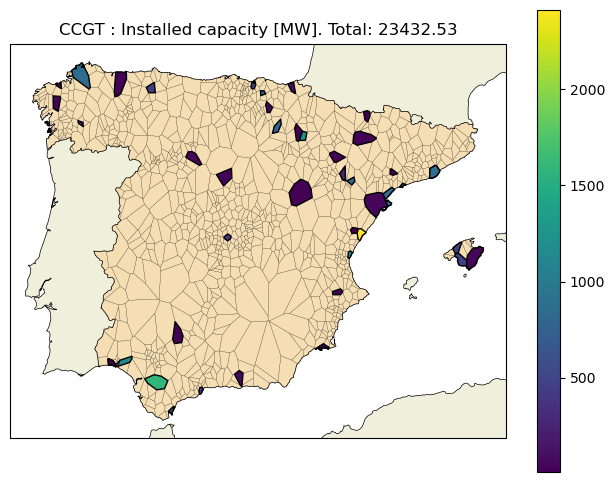

In [8]:
########## Parameters
carrier = 'CCGT'
token_density = 0


##
if 'off' in carrier:
    domain = 'offshore'
else:
    domain = 'onshore'



########## Plot map with Voronoi cells

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_shapes(n, ax, domain=domain)

### Add capacity at Voronoi cells
fun_map_capacity_Voronoi(carrier, token_density, n, ax)

### Add features
fun_map_add_features(ax)

Plot the same but aggregated to a specific NUTS level.

(For **PyPSA-Spain**, you can use NUTS files stored in folder `data_ES/`).

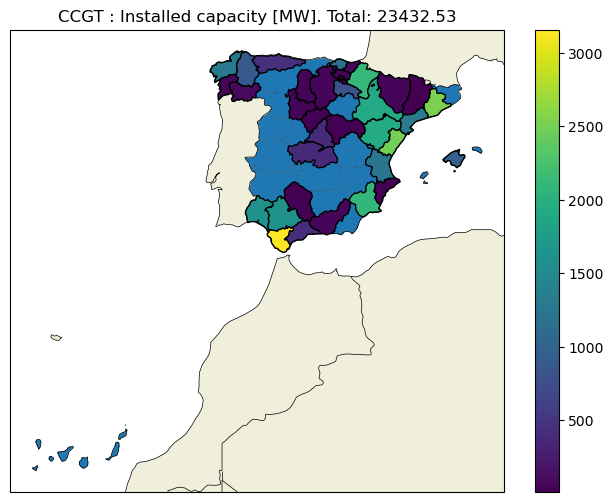

In [9]:
########## Get gdf_NUTS (it must contain at least columns 'NUTS_ID' and 'geometry')

NUTS_level = '3' 
file_NUTS = f'NUTS{NUTS_level}_ES.geojson'
path_NUTS = f'{rootpath}/data_ES/nuts/'
gdf_NUTS = gpd.read_file(path_NUTS+file_NUTS)



########## Plot map at NUTS regions

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax2 = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
#fun_map_network_shapes(n, ax2, domain=domain)

### Add capacity at NUTS regions
fun_map_capacity_NUTS(carrier, token_density, n, gdf_NUTS, ax2)

### Add features
fun_map_add_features(ax2)




In [ ]:
########## Plot the ratio installed capacity versus maximum capacity at each Voronoi cell

carrier = 'onwind'


##### Prepare a df with just the carrier

# filter carrier
df = gg[gg['carrier']==carrier]

# remove zero_capacities
df = df[df['p_nom']>0]


##### Load and prepare gdf with the Voronoi cells and the area
# Use file 'regions_xxshore.geojson' to retrieve 'x' and 'y' coordinates
if 'off' in carrier:
    file = 'regions_offshore.geojson'
    domain = 'offshore'
else:
    file = 'regions_onshore.geojson'
    domain = 'onshore'
    
path = f'{rootpath}/resources/{prefix}/{name}/'

gdf = gpd.read_file(path+file)

gdf.rename(columns={'name': 'bus'}, inplace=True)

### Reproject to get the area
gdf_area = gdf.to_crs(3035)
gdf['area'] = gdf_area.area/1e6

##### Merge and compute
gdf2 =  pd.merge(gdf,df, on='bus')

gdf2['p_nom_ratio'] = gdf2['p_nom'] / gdf2['p_nom_max']



########## Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_shapes(n, ax, domain=domain)


gdf2.plot(ax=ax, column='p_nom_ratio', cmap='viridis', edgecolor="black", legend=True, alpha=1)
ax.set_title(f'{carrier} : Ratio Installed capacity / Max. capacity')


fun_map_add_features(ax)


In [ ]:
########## Plot the capital costs

fig_size = [12,6]

fig, ax = plt.subplots(1,1,figsize=fig_size)


##### Define bins
minimo = 0.95 * gg['capital_cost'].min()
maximo = 1.05 * gg['capital_cost'].max()
ancho = 1000

bins = np.arange(minimo, maximo, 1000)

tech_colors = n.carriers['color']


for carrier in sorted(gg['carrier'].unique()):

    ##### Filtra el carrier
    df = gg[gg['carrier']==carrier]


    ##### si son todos iguales (al segundo decimal)
    if df['capital_cost'].round(2).nunique()==1:

        valor = df['capital_cost'].unique()[0]

        ax.axvline(x=valor, label=carrier, color = tech_colors[carrier])

        print(f'Capital cost for {carrier} is: {valor:.2f} EUR/MW·year')


    else:
        plt.hist(df['capital_cost'], bins=bins, 
                 edgecolor='none', color = tech_colors[carrier],
                 label=carrier, alpha=1)
        
        valor = df['capital_cost'].mean()
        print(f'Average capital cost for {carrier} is: {valor:.2f} EUR/MW·year')


ax.set_title('capital cost')
ax.set_xlabel('EUR/(MW·year)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)


### Variable: `n.loads_t`

In [ ]:

lo_t = n.loads_t['p_set']

In [ ]:
########## Plot the annual load (or spatial density) at each Voronoi cell, and plot also aggregated at some NUTS level

token_density = 1

NUTS_level = '3' # '3'



##### Prepare a df with the annual load, and the column 'bus'
df = lo_t.sum().to_frame(name='load')

df['bus'] = df.index


##### Load and prepare gdf with the Voronoi cells and the area
# Use file 'regions_xxshore.geojson' to retrieve 'x' and 'y' coordinates
if 'off' in carrier:
    file = 'regions_offshore.geojson'
    domain = 'offshore'
else:
    file = 'regions_onshore.geojson'
    domain = 'onshore'
    
path = f'{rootpath}/resources/{prefix}/{name}/'

gdf = gpd.read_file(path+file)

gdf.rename(columns={'name': 'bus'}, inplace=True)


### Reproject to get the area
gdf_area = gdf.to_crs(3035)
gdf['area'] = gdf_area.area/1e6


##### Merge and compute the density
gdf2 =  pd.merge(gdf,df, on='bus')

gdf2['load_density'] = gdf2['load'] / gdf2['area']


##### Make plot
fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_shapes(n, ax, domain=domain)


if token_density == 0:
    gdf2.plot(ax=ax, column='load', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    total_load = gdf2['load'].sum()/1e6 # TWh
    ax.set_title(f'Annual load [TWh]. Total: {total_load:.2f}')

if token_density == 1:
    gdf2.plot(ax=ax, column='load_density', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    ax.set_title('Annual load density [MWh/km2]')


fun_map_add_features(ax)





########## Add a map with the load aggregated at a specific NUTS level
# (according to bus location, not to area overlap)

##### Prepare gdf_NUTS with the NUTS info (including 'x' and 'y' coordinates)

file_NUTs = f'data_ES/nuts/NUTS{NUTS_level}_ES.geojson'

gdf_NUTS = gpd.read_file(rootpath+file_NUTs)
gdf_NUTS.set_index('id', inplace=True)

### Reproject to get the area
gdf_NUTS_area = gdf_NUTS.to_crs(3035)
gdf_NUTS['area'] = gdf_NUTS_area.area/1e6


## Lets use gdf2 to build another gdf with p_nom points instead of Voronoi regions
df0 = gdf2[['load', 'x', 'y']]
geometry = gpd.points_from_xy(df0["x"], df0["y"])
gdf2_points = gpd.GeoDataFrame(df0, geometry=geometry, crs=4326)

## Join points with NUTS
gdf_joined = gdf2_points.sjoin(gdf_NUTS)

## Get aggregated load
agg_load = gdf_joined.groupby("NUTS_ID").load.sum() / 1e6 ### TWh

## Reindex this series to include all the NUTS codes
agg_load = agg_load.reindex(gdf_NUTS.index)

gdf_NUTS['load'] = gdf_NUTS.index.map(agg_load)
gdf_NUTS['load_area'] = gdf_NUTS['load']/gdf_NUTS['area'] * 1e6 # MWh/km2



########## Plot

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


if token_density == 0:
    gdf_NUTS.plot(ax=ax, column='load', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    total_load = gdf_NUTS['load'].sum()
    ax.set_title(f'Annual load [TWh]. Total: {total_load:.2f}')

else:
    gdf_NUTS.plot(ax=ax, column='load_area', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    #ax.set_title('Annual load density [MWh/km2]')


fun_map_add_features(ax)




In [ ]:
########## Plot load time series

fig_size = [10,4]

fig, ax = plt.subplots(figsize=fig_size)

lo_t.loc['2022-04'].plot(ax=ax, alpha=.4, legend=False, linewidth=.3)

ax.grid(True, linestyle='--', alpha=0.75)
ax.set_ylabel('MW')

### Variable: `n.storage_units`

In [ ]:
su = n.storage_units

In [ ]:
########## Make a summary table with capacity per carrier and number of entries with zero capacity

summary_su = su.groupby('carrier').agg(
    Total_capacity=pd.NamedAgg(column='p_nom', aggfunc='sum'),
    Buses=pd.NamedAgg(column='p_nom', aggfunc='size'),
    Buses_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x == 0).sum()),
    Buses_non_zero_capacity=pd.NamedAgg(column='p_nom', aggfunc=lambda x: (x != 0).sum()),
).reset_index()


summary_su

In [ ]:
boundaries[0:2]

In [ ]:
########## Plot the installed capacity (or its spatial density) of a specific storage unit carrier at each Voronoi cell
# and plot the aggregated capapcity (or its spatial density) at a specific NUTS level.

carrier = 'PHS'

token_density = 0


##### Prepare a df with just the carrier

# filter carrier
df = su[su['carrier']==carrier]

# remove zero_capacities
df = df[df['p_nom']>0]


##### Load and prepare gdf with the Voronoi cells and the area
# Use file 'regions_onshore.geojson' to retrieve 'x' and 'y' coordinates

file = 'regions_onshore.geojson'
    
path = f'{rootpath}/resources/{prefix}/{name}/'

gdf = gpd.read_file(path+file)

gdf.rename(columns={'name': 'bus'}, inplace=True)


### Reproject to get the area
gdf_area = gdf.to_crs(3035)
gdf['area'] = gdf_area.area/1e6

##### Merge and compute the density
gdf2 =  pd.merge(gdf,df, on='bus')

gdf2['p_nom_density'] = gdf2['p_nom'] / gdf2['area']



########## Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add network geometry
fun_map_network_shapes(n, ax, domain=domain)


if token_density == 0:
    gdf2.plot(ax=ax, column='p_nom', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    total_capacity = gdf2['p_nom'].sum()
    ax.set_title(f'{carrier} : Installed capacity [MW]. Total: {total_capacity:.2f}')

if token_density == 1:
    gdf2.plot(ax=ax, column='p_nom_density', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    ax.set_title(f'{carrier} : Installed capacity density [MW/km2]')


fun_map_add_features(ax)






########## Add a map with the capacity aggregated at a specific NUTS level
# (according to bus location, not to area overlap)

##### Prepare gdf_NUTS with the NUTS info (including 'x' and 'y' coordinates)

file_NUTs = f'data_ES/nuts/NUTS{NUTS_level}_ES.geojson'

gdf_NUTS = gpd.read_file(rootpath+file_NUTs)
gdf_NUTS.set_index('id', inplace=True)

### Reproject to get the area
gdf_NUTS_area = gdf_NUTS.to_crs(3035)
gdf_NUTS['area'] = gdf_NUTS_area.area/1e6


##### Prepare gdf2_points from gdf2 with p_nom points instead of Voronoi regions
df0 = gdf2[['p_nom', 'x', 'y']]
geometry = gpd.points_from_xy(df0["x"], df0["y"])
gdf2_points = gpd.GeoDataFrame(df0, geometry=geometry, crs=4326)


##### Prepare gdf_joined by joinning gdf2_points and gdf_NUTS
gdf_joined = gdf2_points.sjoin(gdf_NUTS)

## Get aggregated p_nom
agg_p_nom = gdf_joined.groupby("NUTS_ID").p_nom.sum() 

## Reindex this series to include all the NUTS codes
agg_p_nom = agg_p_nom.reindex(gdf_NUTS.index)

gdf_NUTS['p_nom'] = gdf_NUTS.index.map(agg_p_nom)
gdf_NUTS['p_nom_area'] = gdf_NUTS['p_nom']/gdf_NUTS['area']



########## Plot map

fig_size = [8,6]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})




gdf_NUTS.plot(ax=ax)
ax.set_xlim(boundaries[0:2])
ax.set_ylim(boundaries[2:4])


### Add installed capacity
if token_density == 0:
    gdf_NUTS.plot(ax=ax, column='p_nom', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    total_capacity = gdf_NUTS['p_nom'].sum()
    ax.set_title(f'{carrier} : Installed capacity [MW]. Total: {total_capacity:.2f}')

if token_density == 1:
    gdf_NUTS.plot(ax=ax, column='p_nom_area', cmap='viridis', edgecolor="black", legend=True, alpha=1)
    ax.set_title(f'{carrier} : Installed capacity density [MW/km2]')


fun_map_add_features(ax)





In [ ]:
########## Plot the max. hours

fig_size = [8,6]

fig, ax = plt.subplots(figsize=fig_size)

tech_colors = n.carriers['color']

for carrier, grupo in su.groupby('carrier'):
    ax.scatter(grupo['p_nom'], grupo['max_hours'], label=carrier, color=tech_colors[carrier])

ax.set_xlabel('p_nom [MW]')
ax.set_ylabel('max_hours')
ax.set_title('Storate units')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
